In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms
from datetime import datetime
import math
from video_dataset import VideoFrameDataset
from simvp import SimVP
import matplotlib.pyplot as plt

### Load Data

In [2]:
transform = transforms.Compose([
    transforms.Pad(padding=(0, 40), padding_mode='edge'),  # Only pad width
    # transforms.Resize((256, 256)),  # Resize the now square image to 256x256
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5002, 0.4976, 0.4945], std=[0.0555, 0.0547, 0.0566])  # Standard normalization
])

root_dir = '/home/yibin/workspace/dl/final_completion/dataset_student/dataset' # Change this to your dataset directory
train_set = VideoFrameDataset(root_dir, 'train', transform)
val_set = VideoFrameDataset(root_dir, 'val', transform)
unlabeled_set = VideoFrameDataset(root_dir, 'unlabeled', transform)
batch_size = 1
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=4)
unlabeled_loader = DataLoader(unlabeled_set, batch_size=batch_size, shuffle=True, num_workers=4)

### Initialize and Train SimVP

In [3]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model = SimVP(shape_in=[11,1,160,240], out_channel=49)
lr = 1e-4
# criterion = nn.MSELoss()
# criterion = nn.L1Loss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
num_epochs = 50
model.to(device)

SimVP(
  (enc): Encoder(
    (enc): Sequential(
      (0): ConvSC(
        (conv): BasicConv2d(
          (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(2, 16, eps=1e-05, affine=True)
          (act): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (1): ConvSC(
        (conv): BasicConv2d(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (norm): GroupNorm(2, 16, eps=1e-05, affine=True)
          (act): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (2): ConvSC(
        (conv): BasicConv2d(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(2, 16, eps=1e-05, affine=True)
          (act): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (3): ConvSC(
        (conv): BasicConv2d(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (

In [4]:
now = datetime.now()
formatted_time = now.strftime("%m_%d_%Y_%H%M%S")
dir_name = f'simvp-mask-seq-frame_pre-model-{formatted_time}'
os.makedirs(dir_name, exist_ok=True)
train_loss, valid_loss = [], []
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    # train with labeled data
    # print("Labeled")
    train_labeled_loop = tqdm(train_loader, desc='Training Labeled', leave=True)
    for _, first_eleven_frames, last_frame, masks, last_mask, _ in train_labeled_loop:
        # first_eleven_frames = first_eleven_frames.to(device)
        # last_frame = last_frame.to(device)
        first_eleven_masks = masks[:, :11].unsqueeze(2).to(device)
        # last_mask = last_mask.to(torch.long).to(device)
        last_eleven_masks = masks.squeeze(0)[11:].to(torch.long).to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        # outputs = model(first_eleven_frames)
        # loss = criterion(outputs, last_frame)
        outputs = model(first_eleven_masks)
        loss = criterion(outputs, last_eleven_masks)
        # Backward and optimize
        loss.backward()
        optimizer.step()
        # print(loss.item())
        running_loss += loss.item()
    # train with unlabeled data
    train_unlabeled_loop = tqdm(unlabeled_loader, desc='Training Unlabeled', leave=True)
    for  _, first_eleven_frames, last_frame, masks, last_mask, _ in train_unlabeled_loop:
        # first_eleven_frames = first_eleven_frames.to(device)
        # last_frame = last_frame.to(device)
        first_eleven_masks = masks[:, :11].unsqueeze(2).to(device)
        # last_mask = last_mask.to(torch.long).to(device)
        last_eleven_masks = masks.squeeze(0)[11:].to(torch.long).to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        # outputs = model(first_eleven_frames)
        # loss = criterion(outputs, last_frame)
        outputs = model(first_eleven_masks)
        loss = criterion(outputs, last_eleven_masks)
        # Backward and optimize
        loss.backward()
        optimizer.step()
        # print(loss.item())
        running_loss += loss.item()
    train_epoch_loss = running_loss / (len(train_loader) + len(unlabeled_loader))
    train_loss.append(train_epoch_loss)
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_loop = tqdm(val_loader, desc='Validating', leave=True)
        for  _, first_eleven_frames, last_frame, masks, last_mask, _  in val_loop:
            # first_eleven_frames = first_eleven_frames.to(device)
            # last_frame = last_frame.to(device)
            # outputs = model(first_eleven_frames)
            # loss = criterion(outputs, last_frame)
            first_eleven_masks = masks[:, :11].unsqueeze(2).to(device)
            # last_mask = last_mask.to(torch.long).to(device)
            last_eleven_masks = masks.squeeze(0)[11:].to(torch.long).to(device)
            outputs = model(first_eleven_masks)
            loss = criterion(outputs, last_eleven_masks)
            val_loss += loss.item()
    val_epoch_loss = val_loss / len(val_loader)
    valid_loss.append(val_epoch_loss)

    if epoch % 5 == 0:
        path = dir_name + f'/checkpoint_{epoch+1}.pt'
        torch.save(model, path)
    print(f'Epoch {epoch+1}, Train Loss: {train_epoch_loss}, Val Loss: {val_epoch_loss}')

  0%|          | 0/50 [00:00<?, ?it/s]

Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.42428795104473827, Val Loss: 0.2984842160642147


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.279878516530352, Val Loss: 0.25669872789084913


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.24673981448475804, Val Loss: 0.2315151472464204


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.2273299254814961, Val Loss: 0.2177152201756835


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.2152886188985514, Val Loss: 0.20870828475430608


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.2059576396082661, Val Loss: 0.19770173432677984


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.19854005699791014, Val Loss: 0.19946241324022412


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.1924244492250894, Val Loss: 0.19856216007471084


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.18709920705775065, Val Loss: 0.1832446765266359


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.18234233062395028, Val Loss: 0.18253040657564998


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.17785413963028363, Val Loss: 0.17579960834234953


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12, Train Loss: 0.17373090082939183, Val Loss: 0.1767663720585406


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13, Train Loss: 0.17000775750872812, Val Loss: 0.17531266050040722


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14, Train Loss: 0.1668379214592278, Val Loss: 0.1794915367141366


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15, Train Loss: 0.1632589618667428, Val Loss: 0.16524967811629176


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 16, Train Loss: 0.16013276301151408, Val Loss: 0.1814246205613017


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 17, Train Loss: 0.15737276647798717, Val Loss: 0.16720410342141986


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 18, Train Loss: 0.155116165161665, Val Loss: 0.16176651974767448


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19, Train Loss: 0.15216874494523341, Val Loss: 0.15732786809280513


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 20, Train Loss: 0.1499818119301594, Val Loss: 0.1563749583698809


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 21, Train Loss: 0.14763544838250214, Val Loss: 0.15910693287849426


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 22, Train Loss: 0.14511299249689494, Val Loss: 0.15474402288720013


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 23, Train Loss: 0.1430326414852004, Val Loss: 0.1571231710985303


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 24, Train Loss: 0.14168165183572898, Val Loss: 0.15072223317995667


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 25, Train Loss: 0.13890138374721364, Val Loss: 0.18965472880005838


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 26, Train Loss: 0.13740726203311768, Val Loss: 0.1507711727358401


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 27, Train Loss: 0.13527464146805662, Val Loss: 0.1472838205099106


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 28, Train Loss: 0.13324847037305257, Val Loss: 0.1492648040689528


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29, Train Loss: 0.13166740321115192, Val Loss: 0.14973528973013162


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 30, Train Loss: 0.12983844824215132, Val Loss: 0.14871103785932063


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 31, Train Loss: 0.12814368872198142, Val Loss: 0.14860822505876423


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 32, Train Loss: 0.12658010965293007, Val Loss: 0.14360741259157658


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 33, Train Loss: 0.12487613789378, Val Loss: 0.14535567517206072


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 34, Train Loss: 0.12366534790762568, Val Loss: 0.14745229588262737


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 35, Train Loss: 0.12209002860748608, Val Loss: 0.14707470785453916


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 36, Train Loss: 0.12038257090760661, Val Loss: 0.15741878567263484


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 37, Train Loss: 0.11952667488171054, Val Loss: 0.14326301236078143


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 38, Train Loss: 0.11774979359111083, Val Loss: 0.14520302815362812


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39, Train Loss: 0.11638769873950099, Val Loss: 0.14534838226810098


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 40, Train Loss: 0.11498159125114658, Val Loss: 0.14371257639862597


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 41, Train Loss: 0.11474881128993418, Val Loss: 0.14278611995466053


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 42, Train Loss: 0.11240765031061269, Val Loss: 0.14195776404440402


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 43, Train Loss: 0.11196787134624485, Val Loss: 0.14363635699264704


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 44, Train Loss: 0.11026249225105025, Val Loss: 0.1503053616322577


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 45, Train Loss: 0.10932937689271889, Val Loss: 0.146712068406865


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 46, Train Loss: 0.1075668479132333, Val Loss: 0.14367004917934537


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 47, Train Loss: 0.10676655706197821, Val Loss: 0.15075046702474357


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 48, Train Loss: 0.10556395204957308, Val Loss: 0.14099181163497268


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49, Train Loss: 0.10456701670547149, Val Loss: 0.14638579446077346


Training Labeled:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Unlabeled:   0%|          | 0/13000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50, Train Loss: 0.10373463748149307, Val Loss: 0.14766927248984577


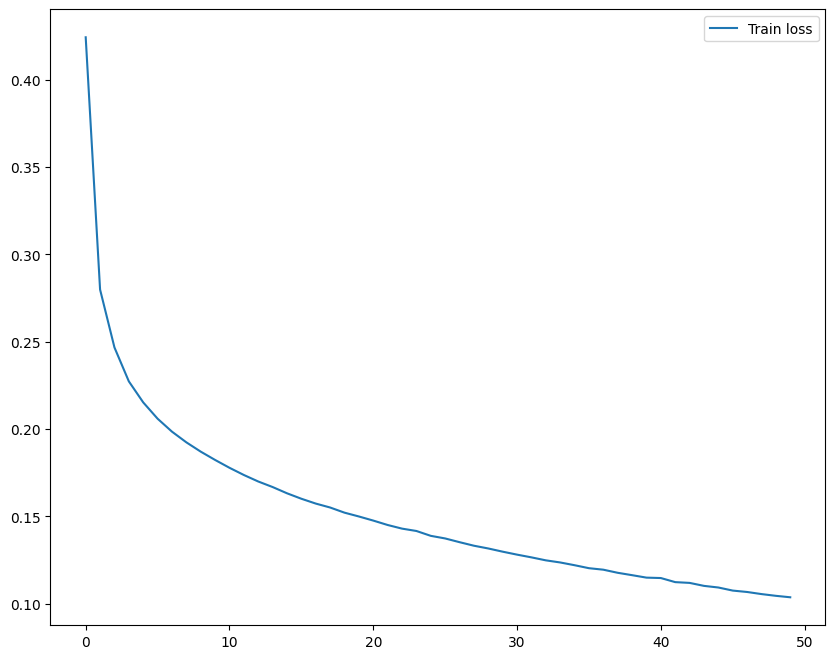

In [5]:
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.legend()
plt.show()

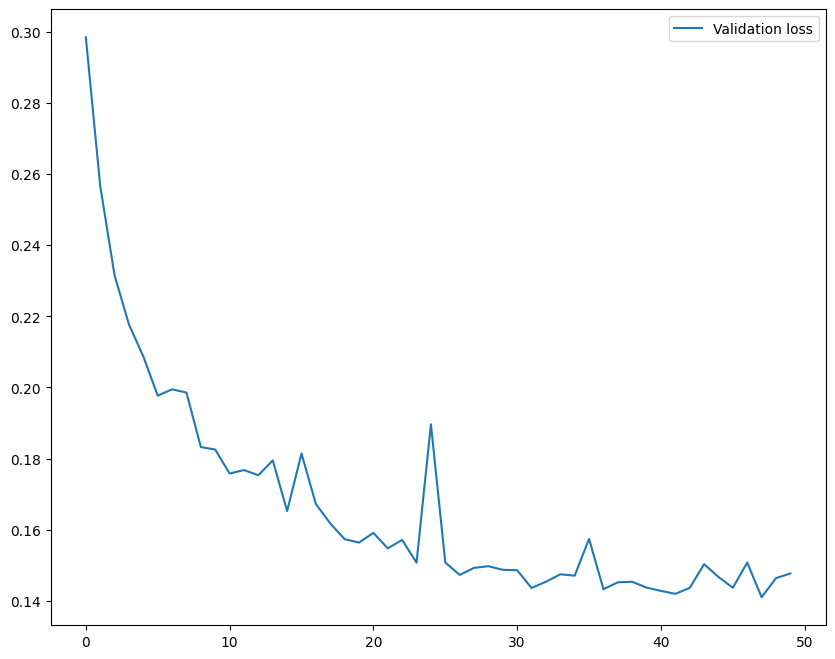

In [6]:
plt.figure(figsize=(10,8))
plt.plot(valid_loss, label='Validation loss')
plt.legend()
plt.show()

### Save Model

In [7]:
path = dir_name + f'/checkpoint.pt'
torch.save(model, path)